# Finding patterns in FTSE-250
This analysis explores the relationship between Bank of England speeches and significant movements in the FTSE-250 index, using sentiment analysis as a core tool.  
### Objective:
To investigate whether the sentiment of central bank speeches—as measured by FinBERT—has predictive power over large market movements in the FTSE-250.

In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
# Set visual style
sns.set(style="whitegrid")

from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import gdown
import os

## Data Preparation

In [2]:
# Load the CSV file
file_path = "C:/Users/germa/OneDrive/LSE DATA ANALYTICS CAREER ACCELERATOR/EMPLOYER PROJECT BoE/Sentiment models/uk_data_with_finbert_scores.csv"
df = pd.read_csv(file_path)

# ensure dates to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
                            
# Show the first few rows and column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1374 non-null   datetime64[ns]
 1   reference           1209 non-null   object        
 2   country             1374 non-null   object        
 3   title               1374 non-null   object        
 4   author              1374 non-null   object        
 5   is_gov              1374 non-null   float64       
 6   text                1374 non-null   object        
 7   clean_text          1374 non-null   object        
 8   tokens              1374 non-null   object        
 9   length              1374 non-null   int64         
 10  fbert_clean         1374 non-null   object        
 11  finbert_pos         1374 non-null   float64       
 12  finbert_neg         1374 non-null   float64       
 13  finbert_neu         1374 non-null   float64     

#
Next, let's **load the FTSE-250 data**

In [3]:
indicators_folder = 'C:/Users/germa/OneDrive/LSE DATA ANALYTICS CAREER ACCELERATOR/EMPLOYER PROJECT BoE/6. Indicators/'
filename_FTSE = 'ftse_clean.csv'

ftse = pd.read_csv(indicators_folder + filename_FTSE)
ftse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    10000 non-null  object 
 1   ftse    10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [4]:
ftse['date'] = pd.to_datetime(ftse['date'], errors='coerce')
ftse

,date,ftse
0,1986-03-04,1548.90000
1,1986-03-05,1569.10000
2,1986-03-06,1566.10000
3,1986-03-07,1573.80000
4,1986-03-10,1572.20000
...,...,...
9995,2025-04-25,8415.24994
9996,2025-04-28,8417.34046
9997,2025-04-29,8463.46245
9998,2025-04-30,8494.84565


### Calculating daily percentage variation in the FTSE

In [5]:
ftse['daily_pct_change'] = ftse['ftse'].pct_change() * 100

# Drop NaN from the first row
ftse.dropna(subset=['daily_pct_change'], inplace=True)

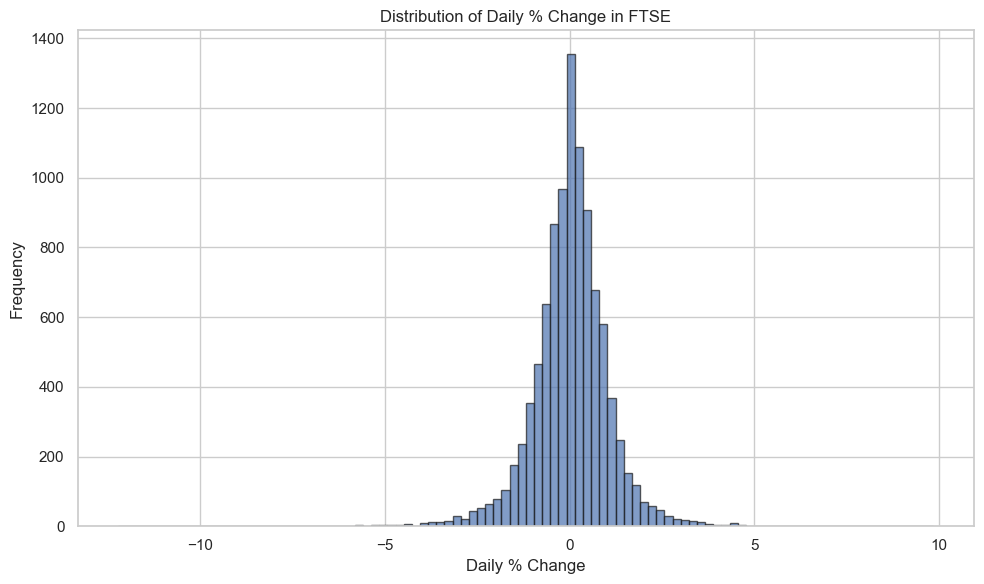

In [6]:
# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(ftse['daily_pct_change'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Daily % Change in FTSE')
plt.xlabel('Daily % Change')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## Finding the most extreme daily changes (+/-2%):

In [7]:
# Identify days with absolute daily change > 2%
extreme_days = ftse[ftse['daily_pct_change'].abs() > 2].copy()

In [8]:
# Find speeches within 3 days before each extreme FTSE movement
matches = []

for idx, row in extreme_days.iterrows():
    target_date = row['date']
    window_start = target_date - pd.Timedelta(days=3)
    
    recent_speeches = df[(df['date'] >= window_start) & (df['date'] < target_date)][
    ['date', 'country', 'title', 'author', 'is_gov', 'finbert_score']
    ].copy()
    
    recent_speeches['ftse_date'] = target_date
    recent_speeches['ftse_change'] = row['daily_pct_change']
    
    matches.append(recent_speeches)

# Combine and show results
results_df = pd.concat(matches, ignore_index=True)

In [9]:
results_df.head()

,date,country,title,author,is_gov,finbert_score,ftse_date,ftse_change
0,1998-09-15,UK,Speech,Edward George,1.0,-0.199338,1998-09-17,-3.000565
1,1998-11-01,UK,"Economic policy, with and without forecasts",budd,0.0,-0.073561,1998-11-04,2.161933
2,1998-11-01,UK,Inflation targeting in practice: the UK experi...,vickers,0.0,0.000268,1998-11-04,2.161933
3,1998-12-01,UK,Speech,governor,0.0,-0.016364,1998-12-02,-5.766562
4,1999-01-12,UK,Speech,Edward George,1.0,0.442215,1999-01-13,-3.041297


#
## Finding the most impactful speakers:
For each extreme FTSE movement day, we find **BoE speeches given in the three days prior, and calculate the impact on the FTSE for each speaker**

### Conditions:
- FTSE-250 moved more than +/- 2% on the day
- Speech was given in the 3 days before
- Author has 3 or more speeches that follow these rules

### Outputs:

**count:** how many of their speeches occurred within 3 days before a large FTSE-250 movement.

**avg_impact:** the average % change in FTSE following their speeches.

**max_impact:** the largest positive FTSE movement linked to their speech.

**min_impact:** the most negative FTSE movement.

**std_impact:** the variability (standard deviation) of the FTSE responses.

**avg_sentiment:** average FinBERT sentiment score across those speeches.


In [10]:
# Group by author to analyse the impact of speeches on FTSE changes and average sentiment
author_impact = results_df.groupby('author').agg(
    count=('ftse_change', 'count'),
    avg_impact=('ftse_change', 'mean'),
    max_impact=('ftse_change', 'max'),
    min_impact=('ftse_change', 'min'),
    std_impact=('ftse_change', 'std'),
    avg_sentiment=('finbert_score', 'mean')
).sort_values(by='avg_impact', ascending=False)

# Filter to authors with at least 3 data points
author_impact_filtered = author_impact[author_impact['count'] >= 3]
author_impact_filtered.sort_values('count', ascending=False)



,count,avg_impact,max_impact,min_impact,std_impact,avg_sentiment
author,,,,,,
Edward George,15,0.061749,3.563635,-3.800057,2.887273,-0.072980
Mark Carney,10,-1.315442,3.037822,-3.622139,2.743925,0.231782
Mervyn King,9,-1.432121,2.638848,-5.001920,2.974250,-0.353776
sentance,9,-0.292591,3.428375,-7.159876,4.020064,-0.313639
tucker,7,-1.048802,2.891645,-3.486669,2.494395,-0.047043
gieve,7,-1.594117,8.052201,-3.858160,4.274112,-0.052521
haldane,6,-0.934224,2.891645,-3.426800,2.758585,-0.192571
cunliffe,6,-1.142424,3.081649,-3.988384,3.101803,-0.136000
hauser,5,-0.744101,3.081649,-3.494087,3.153767,0.077282


## Results:
1. **Negative Sentiment Aligns with Negative Market Impact:**
   - Nickell: worst average sentiment (−0.51) → largest average drop in FTSE (−2.25%)
   - Mervyn King: strongly negative sentiment (−0.53) → strong negative impact (−1.43%)
   - Besley, Bean, Saunders: similar patterns
####
2. **Positive Impact not always corresponds to Positive Sentiment:**
   - Clementi: +2.23% avg impact with +0.09 sentiment
   - Shafik: +2.49% avg impact, yet sentiment is essentially neutral (−0.002)
   - Broadbent and Tenreyro: positive impact with negative sentiment
   - This suggests that markets may interpret even modest or cautiously optimistic tones as reassurance, especially during volatile periods.
#

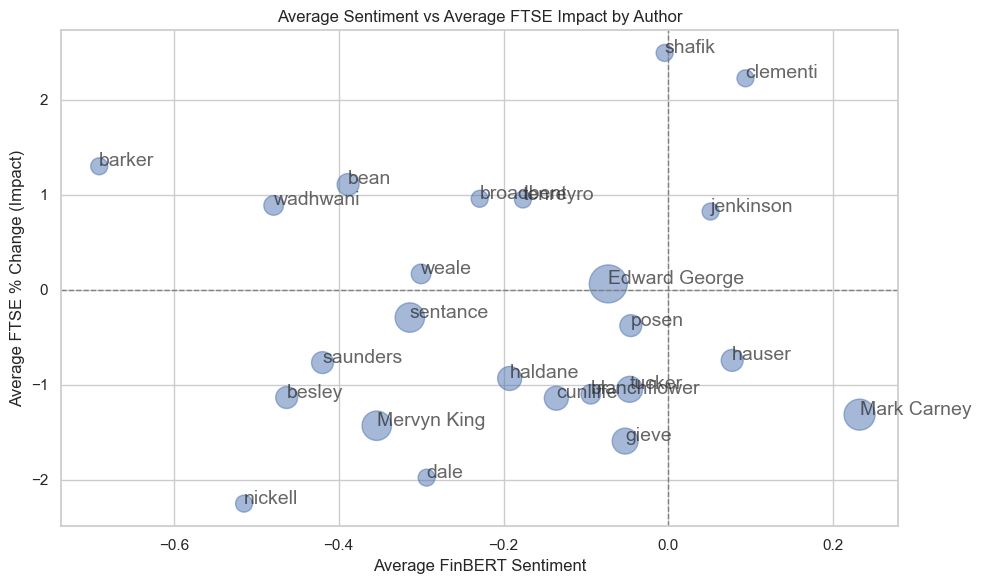

In [16]:
# Prepare the data for plotting
plot_data = author_impact_filtered.copy()

plt.figure(figsize=(10, 6))
# Use 'count' to determine dot size (scale for visibility)
plt.scatter(
    plot_data['avg_sentiment'],
    plot_data['avg_impact'],
    s=plot_data['count'] * 50,  # adjust multiplier for better visibility
    alpha=0.5
)

# Annotate author names
for author, row in plot_data.iterrows():
    plt.annotate(author, (row['avg_sentiment'], row['avg_impact']), fontsize=14, alpha=0.7)

plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Average Sentiment vs Average FTSE Impact by Author')
plt.xlabel('Average FinBERT Sentiment')
plt.ylabel('Average FTSE % Change (Impact)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Conclusions:
- Negative sentiment is often aligned with negative FTSE impact (e.g. Nickell, King).
- Some speakers showed positive FTSE responses despite neutral or negative sentiment, suggesting nuanced market interpretation (e.g. Shafik, Broadbent).
- Edward George appears frequently in the dataset because many of his speeches occurred within three days prior to large FTSE-250 movements. However, his avg_impact is close to zero, meaning neutral or balanced messaging, as reported by his FinBERT sentiment score.
- Despite having a positive average sentiment score (≈ +0.23), **Carney's speeches are associated with a strongly negative average FTSE-250 impact (≈ −1.31%)**. This could be due to uncertainty (e.g. Brexit) or maybe his posititve sentiment in speeches might have led to markets projecting rate hikes.